# Dataset

## Download

In [ ]:
!git clone https://github.com/nikhilroxtomar/Human-Face-Landmark-Detection-in-TensorFlow.git

Cloning into 'Human-Face-Landmark-Detection-in-TensorFlow'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 96 (delta 3), reused 0 (delta 0), pack-reused 88
Unpacking objects: 100% (96/96), 113.36 MiB | 7.06 MiB/s, done.
Updating files: 100% (80/80), done.


# Extract

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [ ]:
#!cp -r /content/drive/Shareddrives/MachineLearning/LaPa.tar.gz /content/
!cp -r /content/drive/MyDrive/LaPa.tar.gz /content/

In [ ]:
!tar -xf /content/LaPa.tar.gz

In [ ]:
#!cp -r /content/drive/Shareddrives/MachineLearning/images_18k.zip /content/
!cp -r /content/drive/MyDrive/images_18k.zip /content/
#!cp -r /content/drive/images_11k.zip /content/

In [ ]:
#!unzip /content/images_18k.zip
#!unzip /content/drive/MyDrive/images_11k.zip
!unzip /content/images_18k.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/HELEN_2702954419_1_4-1.jpg  
  inflating: images/HELEN_2705102720_1_0-1.jpg  
  inflating: images/HELEN_2705102720_1_1-1.jpg  
  inflating: images/HELEN_2705102720_1_2-1.jpg  
  inflating: images/HELEN_2705557901_1_0-1.jpg  
  inflating: images/HELEN_2705557901_1_1-1.jpg  
  inflating: images/HELEN_2705557901_1_3-1.jpg  
  inflating: images/HELEN_2706372454_1_0-1.jpg  
  inflating: images/HELEN_2706372454_1_1-1.jpg  
  inflating: images/HELEN_2706372454_1_2-1.jpg  
  inflating: images/HELEN_2706372454_1_3-1.jpg  
  inflating: images/HELEN_2706940948_1_0-1.jpg  
  inflating: images/HELEN_2706940948_1_1-1.jpg  
  inflating: images/HELEN_2707641297_1_0-0.jpg  
  inflating: images/HELEN_2707641297_1_1-0.jpg  
  inflating: images/HELEN_2707641297_1_2-0.jpg  
  inflating: images/HELEN_2707641297_1_3-0.jpg  
  inflating: images/HELEN_2707641297_1_5-0.jpg  
  inflating: images/HELEN_2707642369_1_0-0.jpg  
  inflating: image

In [ ]:
import shutil
shutil.rmtree('/content/LaPa/train/images/')
shutil.move("/content/images", "/content/LaPa/train") 

'/content/LaPa/train/images'

## Count

In [ ]:
!pip install glob2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from glob import glob

images_count = sorted(glob( "/content/LaPa/train/images/*" ))
landmarks_count = sorted(glob( "/content/LaPa/train/landmarks/*" ))

In [ ]:
print( len(images_count), len(landmarks_count))

18102 18168


# Train

## Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
from glob import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')
%matplotlib inline
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential, Model

from pathlib import Path

## Global Variables

In [ ]:
global image_h
global image_w
global num_landmarks
global train_y_landmarks
global train_y_gender

## Functions

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path):
    train_x = sorted(glob(os.path.join(path, "train", "images", "*.jpg")))
    train_y_landmarks = []
    train_y_gender = []
    for path in train_x:
      temp_split1 = path.split("/")
      temp_split2 = temp_split1[-1].split(".")
      temp_split3 = temp_split2[0].split("-")
      if temp_split3[-1] == "1" or temp_split3[-1] == "0":
        temp_gender = temp_split3[-1]
      else:
        temp_gender = "0"
        print("Error gender annotate in path: " + path + ", " + temp_split3[-1])
      
      temp_landmarks = "/content/LaPa/train/landmarks/" + temp_split3[0] + ".txt"
      train_y_landmarks.append(temp_landmarks)

      #temp_train_y = [train_y_landmarks, train_y_gender]
      train_y_gender.append(temp_gender)
    print( train_x[1], train_x[-1])
    print( train_y_landmarks[1], train_y_landmarks[-1])
    print( train_y_gender[1], train_y_gender[-1])

    return train_x, train_y_landmarks, train_y_gender

def read_image_lankmarks(landmark_path, gender):
    image = cv2.imread(landmark_path, cv2.IMREAD_GRAYSCALE)
    h, w = image.shape


    temp_split1 = landmark_path.split("/")
    temp_split2 = temp_split1[-1].split("-")
    temp_filename = "/content/LaPa/train/landmarks/" + temp_split2[0] + ".txt"

    temp_split3 = temp_split2[-1].split(".")
    temp_gender = float(temp_split3[0])

    """ Lankmarks """
    data = open(temp_filename, "r").read()
    lankmarks = []
    gender_list = [float(gender)]
    
    if temp_gender != gender_list[0]:
      print( "Error in: " + landmark_path)
      print( "Given gender: " + str(gender))
      print( "Gender found: " + temp_split3[0])

    for line in data.strip().split("\n")[1:]:
        x, y = line.split(" ")
        x = float(x)/w
        y = float(y)/h

        lankmarks.append(x)
        lankmarks.append(y)

    lankmarks = np.array(lankmarks, dtype=np.float32)
    gender_list = np.array(gender_list, dtype=np.float32)
    return lankmarks, gender_list

def read_image_preprocess(image_path):
    """ Image """
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    #h, w, _ = image.shape
    image = cv2.resize(image, (image_w, image_h))
    image = image/255.0
    image = image.astype(np.float32)

    return image

def preprocess1(x):
    def f(x):
        x = x.decode()
        image= read_image_preprocess(x)
        return image

    image_temp_list= tf.numpy_function(f, [x], [tf.float32])
    image = image_temp_list[0]
    image.set_shape([image_h, image_w, 3])
    return image

def preprocess2(y_genders, y_landmarks):
    def f(y_genders, y_landmarks):
        temp_y_landmarks = y_landmarks.decode()
        #print(y_genders)
        temp_y_gender = y_genders.decode()
        #print(y_landmarks)

        landmarks, y_gender = read_image_lankmarks(temp_y_landmarks, temp_y_gender)
        return y_gender, landmarks
    print( "x")
    gender, landmarks = tf.numpy_function(f, [y_genders, y_landmarks], [tf.float32, tf.float32])
    print( "xx")
    landmarks.set_shape([num_landmarks * 2])
    gender.set_shape([1])
    print(gender.shape)
    return gender, landmarks

def tf_dataset(x, y_genders, y_landmarks, batch=8):
    print("tf_dataset 1")
    ds1 = tf.data.Dataset.from_tensor_slices(x)
    ds1 = ds1.map(preprocess1)

    ds2 = tf.data.Dataset.from_tensor_slices((y_genders, y_landmarks))
    print("tf_dataset 2")
    ds2 = ds2.map(preprocess2)

    dataset = tf.data.Dataset.zip((ds1, ds2))
    dataset = dataset.batch(batch).prefetch(2)
    return dataset

## Build Model (Architecture)

In [ ]:
# NewArch2
def build_model(input_shape, num_landmarks):
    inputs = L.Input(input_shape)

    backbone = MobileNetV3Large(include_top=False, weights="imagenet", input_tensor=inputs)
    backbone.trainable = True

    x = backbone.output

    # Face Landmark
    landmark_branch = tf.keras.Sequential([
        L.GlobalAveragePooling2D(name='landmark_pooling'),
        L.Dropout(0.2, name='landmark_dropout'),
        L.Dense(num_landmarks*2, activation="sigmoid", name='landmark_output')
    ], name='landmark_branch')
    landmark_output = landmark_branch(x)

    # Gender Detection
    gender_branch = tf.keras.Sequential([
        L.GlobalAveragePooling2D(name='gender_pooling'),
        L.Dropout(0.2, name='gender_dropout'),
        L.Dense(1, activation="sigmoid", name='gender_output')
    ], name='gender_branch')
    gender_output = gender_branch(x)

    # gender_branch.trainable = False
    # for layer in gender_branch.layers:
    #     layer.trainable = False

    # landmark_branch.trainable = False
    # for layer in landmark_branch.layers:
    #     layer.trainable = False

    # backbone.trainable = False
    # for layer in backbone.layers:
    #     layer.trainable = False

    model = Model(inputs=[inputs], outputs=[gender_output, landmark_output])
    return model

In [ ]:
# # NewArch1
# def build_model(input_shape, num_landmarks):
#     inputs = L.Input(input_shape)

#     backbone = MobileNetV3Large(include_top=False, weights="imagenet", input_tensor=inputs)
#     backbone.trainable = True

#     x = backbone.output

#     # Face Landmark
#     landmark_branch = tf.keras.Sequential([
#         L.GlobalAveragePooling2D(name='landmark_pooling'),
#         L.Dropout(0.2, name='landmark_dropout'),
#         L.Dense(num_landmarks*2, activation="sigmoid", name='landmark_output')
#     ], name='landmark_branch')
#     landmark_output = landmark_branch(x)

#     # Gender Detection
#     gender_branch = tf.keras.Sequential([
#         L.Flatten(name='gender_flatten'),
#         L.Dropout(0.2, name='gender_dropout'),
#         L.Dense(256, activation='relu', name='gender_dense2'),
#         L.Dense(1, activation='sigmoid', name='gender_output')
#     ], name='gender_branch')
#     gender_output = gender_branch(x)

#     landmark_branch.trainable = False
#     for layer in landmark_branch.layers:
#         layer.trainable = False

#     # backbone.trainable = False
#     # for layer in backbone.layers:
#     #     layer.trainable = False

#     model = Model(inputs=[inputs], outputs=[gender_output, landmark_output])
#     return model

In [ ]:
"""
def build_model(input_shape, num_landmarks):
    inputs = L.Input(input_shape)

    backbone = MobileNetV3Large(include_top=False, weights="imagenet", input_tensor=inputs)
    backbone.trainable = True

    x = backbone.output

    # Face Landmark
    landmark_branch = tf.keras.Sequential([
        L.GlobalAveragePooling2D(name='landmark_pooling'),
        L.Dropout(0.2, name='landmark_dropout'),
        L.Dense(num_landmarks*2, activation="sigmoid", name='landmark_output')
    ], name='landmark_branch')
    landmark_output = landmark_branch(x)

    # Gender Detection
    gender_branch = tf.keras.Sequential([
        L.Dense(64, activation='relu', name='gender_dense1'),
        L.Flatten(name='gender_flatten'),
        L.Dense(64, activation='relu', name='gender_dense2'),
        L.Dense(1, activation='sigmoid', name='gender_output')
    ], name='gender_branch')
    gender_output = gender_branch(x)

    gender_branch.trainable = False
    for layer in gender_branch.layers:
        layer.trainable = False

    model = Model(inputs=[inputs], outputs=[gender_output, landmark_output])
    return model
"""

'\ndef build_model(input_shape, num_landmarks):\n    inputs = L.Input(input_shape)\n\n    backbone = MobileNetV3Large(include_top=False, weights="imagenet", input_tensor=inputs)\n    backbone.trainable = True\n\n    x = backbone.output\n\n    # Face Landmark\n    landmark_branch = tf.keras.Sequential([\n        L.GlobalAveragePooling2D(name=\'landmark_pooling\'),\n        L.Dropout(0.2, name=\'landmark_dropout\'),\n        L.Dense(num_landmarks*2, activation="sigmoid", name=\'landmark_output\')\n    ], name=\'landmark_branch\')\n    landmark_output = landmark_branch(x)\n\n    # Gender Detection\n    gender_branch = tf.keras.Sequential([\n        L.Dense(64, activation=\'relu\', name=\'gender_dense1\'),\n        L.Flatten(name=\'gender_flatten\'),\n        L.Dense(64, activation=\'relu\', name=\'gender_dense2\'),\n        L.Dense(1, activation=\'sigmoid\', name=\'gender_output\')\n    ], name=\'gender_branch\')\n    gender_output = gender_branch(x)\n\n    gender_branch.trainable = False

In [ ]:
"""
def build_model(input_shape, num_landmarks):
    inputs = L.Input(input_shape)

    backbone = MobileNetV3Large(include_top=False, weights="imagenet", input_tensor=inputs)
    backbone.trainable = False

    x = backbone.output

    # Face Landmark
    landmark_branch = tf.keras.Sequential([
        L.GlobalAveragePooling2D(name='landmark_pooling'),
        L.Dropout(0.2, name='landmark_dropout'),
        L.Dense(num_landmarks*2, activation="sigmoid", name='landmark_output')
    ], name='landmark_branch')
    landmark_output = landmark_branch(x)

    # Gender Detection
    gender_branch = tf.keras.Sequential([
        L.Dense(128, activation='relu', name='gender_dense1'),
        L.Flatten(name='gender_flatten'),
        L.Dense(128, activation='relu', name='gender_dense2'),
        L.Dense(1, activation='sigmoid', name='gender_output')
    ], name='gender_branch')
    gender_output = gender_branch(x)

    landmark_branch.trainable = False
    for layer in landmark_branch.layers:
        layer.trainable = False

    backbone.trainable = False
    for layer in backbone.layers:
        layer.trainable = False

    model = Model(inputs=[inputs], outputs=[gender_output, landmark_output])
    return model
"""


'\ndef build_model(input_shape, num_landmarks):\n    inputs = L.Input(input_shape)\n\n    backbone = MobileNetV3Large(include_top=False, weights="imagenet", input_tensor=inputs)\n    backbone.trainable = False\n\n    x = backbone.output\n\n    # Face Landmark\n    landmark_branch = tf.keras.Sequential([\n        L.GlobalAveragePooling2D(name=\'landmark_pooling\'),\n        L.Dropout(0.2, name=\'landmark_dropout\'),\n        L.Dense(num_landmarks*2, activation="sigmoid", name=\'landmark_output\')\n    ], name=\'landmark_branch\')\n    landmark_output = landmark_branch(x)\n\n    # Gender Detection\n    gender_branch = tf.keras.Sequential([\n        L.Dense(128, activation=\'relu\', name=\'gender_dense1\'),\n        L.Flatten(name=\'gender_flatten\'),\n        L.Dense(128, activation=\'relu\', name=\'gender_dense2\'),\n        L.Dense(1, activation=\'sigmoid\', name=\'gender_output\')\n    ], name=\'gender_branch\')\n    gender_output = gender_branch(x)\n\n    landmark_branch.trainable = 

In [ ]:
"""
def build_model(input_shape, num_landmarks):
    inputs = L.Input(input_shape)

    backbone = MobileNetV3Large(include_top=False, weights="imagenet", input_tensor=inputs)
    backbone.trainable = False

    x = backbone.output

    # Face Landmark
    landmark_branch = tf.keras.Sequential([
        L.GlobalAveragePooling2D(name='landmark_pooling'),
        L.Dropout(0.2, name='landmark_dropout'),
        L.Dense(num_landmarks*2, activation="sigmoid", name='landmark_output')
    ], name='landmark_branch')
    landmark_output = landmark_branch(x)

    # Gender Detection
    gender_branch = tf.keras.Sequential([
        L.Dense(128, activation='relu', name='gender_dense1'),
        L.Flatten(name='gender_flatten'),
        L.Dense(128, activation='relu', name='gender_dense2'),
        L.Dense(1, activation='sigmoid', name='gender_output')
    ], name='gender_branch')
    gender_output = gender_branch(x)

    landmark_branch.trainable = False
    for layer in landmark_branch.layers:
        layer.trainable = False

    backbone.trainable = False
    for layer in backbone.layers:
        layer.trainable = False

    model = Model(inputs=[inputs], outputs=[gender_output, landmark_output])
    return model
"""


'\ndef build_model(input_shape, num_landmarks):\n    inputs = L.Input(input_shape)\n\n    backbone = MobileNetV3Large(include_top=False, weights="imagenet", input_tensor=inputs)\n    backbone.trainable = False\n\n    x = backbone.output\n\n    # Face Landmark\n    landmark_branch = tf.keras.Sequential([\n        L.GlobalAveragePooling2D(name=\'landmark_pooling\'),\n        L.Dropout(0.2, name=\'landmark_dropout\'),\n        L.Dense(num_landmarks*2, activation="sigmoid", name=\'landmark_output\')\n    ], name=\'landmark_branch\')\n    landmark_output = landmark_branch(x)\n\n    # Gender Detection\n    gender_branch = tf.keras.Sequential([\n        L.Dense(128, activation=\'relu\', name=\'gender_dense1\'),\n        L.Flatten(name=\'gender_flatten\'),\n        L.Dense(128, activation=\'relu\', name=\'gender_dense2\'),\n        L.Dense(1, activation=\'sigmoid\', name=\'gender_output\')\n    ], name=\'gender_branch\')\n    gender_output = gender_branch(x)\n\n    landmark_branch.trainable = 

## Initialize variables and dataset

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory for storing files """
create_dir("files")

""" Hyperparameters """
image_h = 224
image_w = 224
num_landmarks = 106
input_shape = (image_h, image_w, 3)
batch_size = 32
lr = 1e-9
#lr = 1e-06
num_epochs = 100

In [ ]:
""" Paths """
dataset_path = "/content/LaPa"
model_path = "/content/drive/MyDrive/Gender-Landmark_224/Results/mnv3_large_224_v4_newArch2_trainBoth_run2/model.h5"
csv_path = "/content/drive/MyDrive/Gender-Landmark_224/Results/mnv3_large_224_v4_newArch2_trainBoth_run2/data.csv"

""" Loading the dataset """
#(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)
train_x, train_y_landmarks, train_y_gender = load_dataset(dataset_path)
print(f"Train: {len(train_x)}/{len(train_y_landmarks)}/{len(train_y_gender)}")
print("")

print( len(train_x), len(train_x[0]), train_x[0])
print( len(train_y_landmarks), len(train_y_landmarks[0]), train_y_landmarks[0])
print( len(train_y_gender), len(str(train_y_gender[0])), train_y_gender[0])
""" Dataset Pipeline """
#train_ds = tf_dataset(train_x, train_y_gender, train_y_landmarks, batch=batch_size)
train_ds = tf_dataset(train_x, train_y_gender, train_x, batch=batch_size)
#valid_ds = tf_dataset(train_x, train_y_landmarks, train_y_gender , batch=batch_size)
#valid_ds = tf_dataset(valid_x, valid_y, batch=batch_size)

/content/LaPa/train/images/10003645676_0-0.jpg /content/LaPa/train/images/LFPW_image_train_0871_3-1.jpg
/content/LaPa/train/landmarks/10003645676_0.txt /content/LaPa/train/landmarks/LFPW_image_train_0871_3.txt
0 1
Train: 18102/18102/18102

18102 46 /content/LaPa/train/images/10001436895_0-0.jpg
18102 47 /content/LaPa/train/landmarks/10001436895_0.txt
18102 1 0
tf_dataset 1
tf_dataset 2
x
xx
(1,)


## Pandas

In [ ]:
train_ds

In [ ]:
import pandas as pd

# convert to dataframe
df = pd.DataFrame()
df['image'], df['landmarks'], df['gender'] = train_x, train_y_landmarks, train_y_gender
#df['image'] = train_x
df.head()

In [ ]:
def read_image_lankmarks(landmark_paths):
    result_landmarks = []
    for image_landmark_path in tqdm(landmark_paths):
      """ Lankmarks """
      data = open(image_landmark_path, "r").read()
      lankmarks = []

      for line in data.strip().split("\n")[1:]:
          x, y = line.split(" ")
          x = float(x)/512
          y = float(y)/512

          lankmarks.append(x)
          lankmarks.append(y)

      lankmarks = np.array(lankmarks, dtype=np.float32)
      result_landmarks.append(lankmarks)
    result_landmarks = np.array(result_landmarks)
    return result_landmarks

In [ ]:
y_landmarks = read_image_lankmarks(df['landmarks'])

In [ ]:
y_landmarks.shape

In [ ]:
from PIL import Image
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=False)
        img = img.resize((512, 512), Image.ANTIALIAS)
        img = np.array(img)
        img = img/255.0
        img = img.astype(np.float32)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 512, 512, 3)
    return features

X = extract_features(df['image'])

In [ ]:
X.shape

In [ ]:
# normalize the images
#X = X/255.0

In [ ]:
X.shape

In [ ]:
y_gender = np.array(df['gender'])

## Compile

In [ ]:
""" Model """
model = build_model(input_shape, num_landmarks)
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=['binary_crossentropy', 'mean_squared_error'],
              loss_weights=[0.5, 0.5],
              metrics=['accuracy'])

12683000/12683000 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

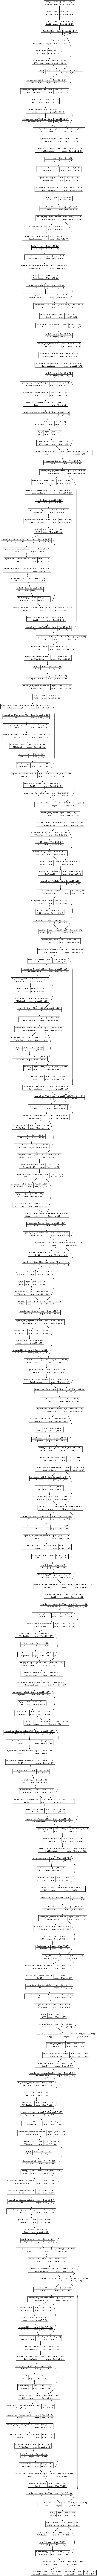

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Load Weights

In [ ]:
#model.load_weights( "/content/drive/MyDrive/Gender-Landmark_224/Checkpoints/mnv3_large_224_v2_genderFalse/Gender_e30.ckpt")#
#model.load_weights( "/content/drive/MyDrive/Gender-Landmark_224/Checkpoints/mnv3_large_224_v2_landmarkFalse/Gender_e30.ckpt")
#model.load_weights( "/content/drive/MyDrive/Gender-Landmark_224/Checkpoints/mnv3_large_224_v2_genderFalse-2/Gender_e30.ckpt")
model.load_weights( "/content/drive/MyDrive/Gender-Landmark_224/Checkpoints/mnv3_large_224_v4_newArch2_trainLandmark_run4/Gender_e30.ckpt")
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=['binary_crossentropy', 'mean_squared_error'],
              loss_weights=[0.5, 0.5],
              metrics=['accuracy'])

## Train

In [ ]:
train_ds

In [ ]:
for x, y in train_ds:
  #print(x, y)
  print(len(y[0]), y[0])
  break

In [ ]:
#checkpoint_path = "/content/drive/MyDrive/Gender-Landmark_257/Ck_5k_v1/Gender_e1-15.ckpt"
checkpoint_path = "/content/drive/MyDrive/Gender-Landmark_224/Checkpoints/mnv3_large_224_v4_newArch2_trainBoth_run2/Gender_e30.ckpt"
""" Training """
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True, monitor='val_loss'),
    ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose= 1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-20, verbose=1),
    CSVLogger(csv_path, append=True),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]


history = model.fit(train_ds,
    validation_data=train_ds,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
566/566 [==============================] - ETA: 0s - loss: 1.9384e-04 - gender_branch_loss: 4.0347e-06 - landmark_branch_loss: 3.8364e-04 - gender_branch_accuracy: 1.0000 - landmark_branch_accuracy: 0.5808
Epoch 1: val_loss improved from inf to 0.00086, saving model to /content/drive/MyDrive/Gender-Landmark_224/Results/mnv3_large_224_v4_newArch2_trainBoth_run2/model.h5

Epoch 1: saving model to /content/drive/MyDrive/Gender-Landmark_224/Checkpoints/mnv3_large_224_v4_newArch2_trainBoth_run2/Gender_e30.ckpt
566/566 [==============================] - 417s 675ms/step - loss: 1.9384e-04 - gender_branch_loss: 4.0347e-06 - landmark_branch_loss: 3.8364e-04 - gender_branch_accuracy: 1.0000 - landmark_branch_accuracy: 0.5808 - val_loss: 8.6475e-04 - val_gender_branch_loss: 0.0014 - val_landmark_branch_loss: 3.2131e-04 - val_gender_branch_accuracy: 0.9996 - val_landmark_branch_accuracy: 0.5984 - lr: 1.0000e-09
Epoch 2/100
566/566 [==============================] - ETA: 0s - loss: 1.93

In [ ]:
#checkpoint_path = "/content/drive/MyDrive/Gender-Landmark_257/Ck_5k_v1/Gender_e1-15.ckpt"
checkpoint_path = "/content/drive/MyDrive/Gender-Landmark_224/Checkpoints/mnv3_large_224_v2_landmarkFalse/Gender_e30.ckpt"
""" Training """
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True, monitor='val_loss'),
    ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose= 1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-10, verbose=1),
    CSVLogger(csv_path, append=True),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]


history = model.fit(train_ds,
    validation_data=train_ds,
    epochs=100,
    callbacks=callbacks
)

In [ ]:
#checkpoint_path = "/content/drive/MyDrive/Gender-Landmark_257/Ck_5k_v1/Gender_e1-15.ckpt"
checkpoint_path = "/content/drive/MyDrive/Gender-Landmark_224/Checkpoints/mnv3_large_224_v2_genderFalse-2/Gender_e30.ckpt"
""" Training """
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True, monitor='val_loss'),
    ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose= 1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path, append=True),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]


history = model.fit(train_ds,
    validation_data=train_ds,
    epochs=100,
    callbacks=callbacks
)

In [ ]:
#checkpoint_path = "/content/drive/MyDrive/Gender-Landmark_257/Ck_5k_v1/Gender_e1-15.ckpt"
checkpoint_path = "/content/drive/MyDrive/Gender-Landmark_224/Checkpoints/mnv3_large_224_v2_genderFalse-2/Gender_e30.ckpt"
""" Training """
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True, monitor='val_loss'),
    ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose= 1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path, append=True),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]


history = model.fit(train_ds,
    validation_data=train_ds,
    epochs=100,
    callbacks=callbacks
)

In [ ]:
import shutil
shutil.move("/content/files", "/content/drive/MyDrive/Gender-Landmark_257/result") 

'/content/drive/MyDrive/Gender-Landmark_257/result'

In [ ]:
shutil.move("/content/Ck_5k_v1", "/content/drive/MyDrive/Gender-Landmark_257/Checkpoints") 

'/content/drive/MyDrive/Gender-Landmark_257/Checkpoints/Ck_5k_v1'

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 2])
plt.legend()
plt.show()

In [ ]:
# train model
history = model.fit(x=X, y=[y_landmarks, y_gender], batch_size=32, epochs=30, validation_split=0.2)

In [ ]:
""" Training """
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path, append=True),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

"""
model.fit(train_ds,
    validation_data=valid_ds,
    epochs=num_epochs,
    callbacks=callbacks
)
"""

# train model
history = model.fit(x=X, y=[y_landmarks, y_gender], batch_size=32, epochs=30, validation_split=0.2, callbacks=callbacks)


## Save Model

In [ ]:
TF_LITE_MODEL_FILE_NAME = "/content/drive/MyDrive/Gender-Landmark_224/mnv3_large_224_v4_newArch2_trainLandmark_run4.tflite"

In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = tf_lite_converter.convert()

In [ ]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

3486248

In [ ]:
!pwd

/content


# Testing model

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
#from train import create_dir, load_dataset

def load_dataset2(path):
    train_x = sorted(glob(os.path.join(path, "train", "images", "*.jpg")))
    train_y = sorted(glob(os.path.join(path, "train", "landmarks", "*.txt")))

    valid_x = sorted(glob(os.path.join(path, "val", "images", "*.jpg")))
    valid_y = sorted(glob(os.path.join(path, "val", "landmarks", "*.txt")))

    test_x = sorted(glob(os.path.join(path, "test", "images", "*.jpg")))
    test_y = sorted(glob(os.path.join(path, "test", "landmarks", "*.txt")))

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

global image_h
global image_w
global num_landmarks

def plot_lankmarks(image, landmarks):
    h, w, _ = image.shape
    radius = int(h * 0.005)

    for i in range(0, len(landmarks), 2):
        x = int(landmarks[i] * w)
        y = int(landmarks[i+1] * h)

        image = cv2.circle(image, (x, y), radius, (255, 0, 0), -1)

    return image

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("/content/drive/MyDrive/Gender-Landmark_224/mnv3_large_224_v2_genderFalse-2")

    """ Hyperparameters """
    image_h = 224
    image_w = 224
    num_landmarks = 106

    """ Paths """
    dataset_path = "/content/LaPa"
    model_path = "/content/drive/MyDrive/Gender-Landmark_224/Results/mnv3_large_224_v2_genderFalse-2/model.h5"
    """ Loading the dataset """
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset2(dataset_path)
    print(f"Train: {len(train_x)}/{len(train_y)} - Valid: {len(valid_x)}/{len(valid_y)} - Test: {len(test_x)}/{len(test_x)}")
    print("")

    """ Load the model """
    model = tf.keras.models.load_model(model_path)
    # model.summary()

    gender_codes = [ "Female", "Male"]
    saveN= 0
    """ Prediction """
    for x, y in tqdm(zip(valid_x, valid_y), total=len(valid_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        image_x = image
        image = cv2.resize(image, (image_w, image_h))
        image = image/255.0 ## (512, 512, 3)
        image = np.expand_dims(image, axis=0) ## (1, 512, 512, 3)
        image = image.astype(np.float32)

        """ Landmarks """
        data = open(y, "r").read()
        landmarks = []
        for line in data.strip().split("\n")[1:]:
            x, y = line.split(" ")
            x = float(x)/image_x.shape[1]
            y = float(y)/image_x.shape[0]

            landmarks.append(x)
            landmarks.append(y)

        landmarks = np.array(landmarks, dtype=np.float32)

        """ Prediction """
        gender_pred, landmark_pred = model.predict(image, verbose=0)
        print(gender_pred)
        landmark_pred = landmark_pred[0].astype(np.float32)

        """ Saving the results """
        gt_landmarks = plot_lankmarks(image_x.copy(), landmarks)
        pred_landmarks = plot_lankmarks(image_x.copy(), landmark_pred)
        line = np.ones((image_x.shape[0], 10, 3)) * 255

        cat_images = np.concatenate([gt_landmarks, line, pred_landmarks], axis=1)
        cv2.imwrite(f"/content/drive/MyDrive/Gender-Landmark_224/mnv3_large_224_v2_genderFalse-2/{name}--{gender_codes[round(gender_pred[0][0])]}.png", cat_images)
        saveN += 1
        if saveN == 150:
          break

Train: 18102/18168 - Valid: 2000/2000 - Test: 2000/2000



  0%|          | 1/2000 [00:01<54:18,  1.63s/it]

[[0.04896644]]
[[0.00388564]]


  0%|          | 3/2000 [00:02<17:25,  1.91it/s]

[[0.06409551]]
[[0.70329183]]


  0%|          | 4/2000 [00:02<12:52,  2.58it/s]

[[0.9999374]]


  0%|          | 6/2000 [00:02<11:51,  2.80it/s]

[[0.99981606]]


  0%|          | 7/2000 [00:03<10:00,  3.32it/s]

[[0.99969614]]


  0%|          | 8/2000 [00:03<09:48,  3.38it/s]

[[0.00537439]]


  0%|          | 9/2000 [00:03<08:38,  3.84it/s]

[[0.891214]]
[[1.]]


  1%|          | 11/2000 [00:03<07:53,  4.20it/s]

[[0.9847025]]
[[0.99961644]]


  1%|          | 13/2000 [00:04<07:12,  4.59it/s]

[[0.9917556]]
[[0.99858195]]


  1%|          | 15/2000 [00:05<08:59,  3.68it/s]

[[0.99395806]]


  1%|          | 16/2000 [00:05<08:43,  3.79it/s]

[[0.00013317]]


  1%|          | 17/2000 [00:05<08:42,  3.79it/s]

[[0.99832577]]


  1%|          | 18/2000 [00:05<08:26,  3.91it/s]

[[0.9757177]]


  1%|          | 19/2000 [00:06<08:42,  3.79it/s]

[[0.9893499]]


  1%|          | 20/2000 [00:06<08:24,  3.92it/s]

[[0.99656385]]


  1%|          | 21/2000 [00:06<08:35,  3.84it/s]

[[0.13382979]]


  1%|          | 22/2000 [00:06<08:33,  3.85it/s]

[[0.38214508]]


  1%|          | 23/2000 [00:07<08:09,  4.04it/s]

[[0.06452475]]


  1%|          | 24/2000 [00:07<08:36,  3.82it/s]

[[0.07327188]]


  1%|▏         | 25/2000 [00:07<08:57,  3.67it/s]

[[0.00041422]]


  1%|▏         | 26/2000 [00:08<09:54,  3.32it/s]

[[7.0606606e-05]]


  1%|▏         | 27/2000 [00:08<09:32,  3.44it/s]

[[0.2066491]]
[[0.8499279]]


  1%|▏         | 29/2000 [00:09<10:18,  3.19it/s]

[[0.65355927]]


  2%|▏         | 30/2000 [00:09<10:35,  3.10it/s]

[[8.297383e-06]]


  2%|▏         | 31/2000 [00:09<09:06,  3.60it/s]

[[2.471989e-05]]
[[0.9998252]]


  2%|▏         | 32/2000 [00:09<08:31,  3.85it/s]

[[0.999999]]


  2%|▏         | 34/2000 [00:10<10:49,  3.02it/s]

[[0.00210765]]


  2%|▏         | 35/2000 [00:10<09:22,  3.50it/s]

[[4.4826396e-05]]
[[0.9973672]]


  2%|▏         | 37/2000 [00:11<09:34,  3.42it/s]

[[0.10120779]]


  2%|▏         | 38/2000 [00:11<09:55,  3.30it/s]

[[0.9915063]]


  2%|▏         | 39/2000 [00:11<09:09,  3.57it/s]

[[0.99108434]]
[[6.0983257e-05]]


  2%|▏         | 41/2000 [00:12<08:15,  3.95it/s]

[[0.00230317]]


  2%|▏         | 42/2000 [00:12<08:27,  3.86it/s]

[[0.98497874]]


  2%|▏         | 43/2000 [00:12<07:34,  4.30it/s]

[[0.8962099]]
[[3.8138094e-08]]


  2%|▏         | 45/2000 [00:13<07:33,  4.31it/s]

[[0.8934543]]
[[0.97980654]]


  2%|▏         | 47/2000 [00:13<08:14,  3.95it/s]

[[0.98484457]]


  2%|▏         | 48/2000 [00:14<07:46,  4.19it/s]

[[0.00028928]]
[[1.]]


  2%|▎         | 50/2000 [00:14<08:40,  3.75it/s]

[[0.99998814]]


  3%|▎         | 51/2000 [00:14<07:44,  4.19it/s]

[[0.6909183]]
[[0.9999942]]


  3%|▎         | 53/2000 [00:15<07:16,  4.46it/s]

[[0.9713629]]
[[0.9990565]]


  3%|▎         | 55/2000 [00:15<07:26,  4.36it/s]

[[2.0284797e-06]]
[[7.704047e-06]]


  3%|▎         | 57/2000 [00:16<08:38,  3.75it/s]

[[0.8234916]]


  3%|▎         | 58/2000 [00:16<07:44,  4.18it/s]

[[0.00100221]]
[[0.99998677]]


  3%|▎         | 61/2000 [00:17<06:24,  5.05it/s]

[[1.]]
[[0.01081201]]


  3%|▎         | 62/2000 [00:17<06:34,  4.92it/s]

[[1.]]


  3%|▎         | 63/2000 [00:17<07:27,  4.32it/s]

[[0.01625649]]


  3%|▎         | 64/2000 [00:17<07:26,  4.34it/s]

[[9.0722424e-05]]


  3%|▎         | 65/2000 [00:18<07:00,  4.60it/s]

[[0.00022688]]
[[2.203846e-07]]


  3%|▎         | 67/2000 [00:18<07:03,  4.56it/s]

[[0.0004426]]


  3%|▎         | 68/2000 [00:18<07:12,  4.47it/s]

[[0.99997735]]


  3%|▎         | 69/2000 [00:18<07:20,  4.38it/s]

[[1.2951354e-05]]


  4%|▎         | 70/2000 [00:19<07:24,  4.34it/s]

[[0.998534]]


  4%|▎         | 71/2000 [00:19<08:24,  3.82it/s]

[[0.99940526]]


  4%|▎         | 72/2000 [00:19<08:21,  3.84it/s]

[[0.5586654]]


  4%|▎         | 73/2000 [00:20<08:26,  3.81it/s]

[[0.00511131]]


  4%|▎         | 74/2000 [00:20<09:32,  3.36it/s]

[[1.]]
[[0.00048228]]


  4%|▍         | 75/2000 [00:20<11:13,  2.86it/s]

[[0.17955725]]


  4%|▍         | 77/2000 [00:22<17:15,  1.86it/s]

[[0.169657]]


  4%|▍         | 78/2000 [00:22<15:04,  2.12it/s]

[[0.92542714]]


  4%|▍         | 79/2000 [00:23<12:56,  2.48it/s]

[[0.971813]]


  4%|▍         | 80/2000 [00:23<12:16,  2.61it/s]

[[0.9929575]]


  4%|▍         | 81/2000 [00:23<11:38,  2.75it/s]

[[0.01448989]]


  4%|▍         | 82/2000 [00:23<10:47,  2.96it/s]

[[0.9997893]]


  4%|▍         | 83/2000 [00:24<10:54,  2.93it/s]

[[0.00033894]]


  4%|▍         | 84/2000 [00:24<10:07,  3.15it/s]

[[1.]]


  4%|▍         | 85/2000 [00:24<09:00,  3.54it/s]

[[0.98356164]]
[[0.02311554]]


  4%|▍         | 87/2000 [00:25<07:40,  4.15it/s]

[[0.99996555]]
[[0.04243249]]


  4%|▍         | 89/2000 [00:25<07:58,  3.99it/s]

[[1.]]


  4%|▍         | 90/2000 [00:25<08:13,  3.87it/s]

[[0.04510434]]


  5%|▍         | 91/2000 [00:26<08:10,  3.90it/s]

[[2.0432377e-05]]


  5%|▍         | 92/2000 [00:26<07:46,  4.09it/s]

[[0.9999754]]


  5%|▍         | 93/2000 [00:26<07:30,  4.23it/s]

[[2.688948e-06]]


  5%|▍         | 94/2000 [00:26<07:57,  4.00it/s]

[[1.]]


  5%|▍         | 95/2000 [00:27<07:13,  4.40it/s]

[[0.01217468]]
[[0.9997818]]


  5%|▍         | 97/2000 [00:27<07:06,  4.46it/s]

[[0.9999997]]


  5%|▍         | 98/2000 [00:27<07:07,  4.45it/s]

[[0.23124497]]


  5%|▍         | 99/2000 [00:28<07:47,  4.06it/s]

[[0.75979084]]


  5%|▌         | 100/2000 [00:28<07:27,  4.24it/s]

[[0.9994862]]


  5%|▌         | 101/2000 [00:28<07:11,  4.40it/s]

[[0.78881085]]
[[0.99997103]]


  5%|▌         | 103/2000 [00:28<07:00,  4.51it/s]

[[0.05666468]]


  5%|▌         | 104/2000 [00:29<06:48,  4.64it/s]

[[0.9999688]]
[[0.00020951]]


  5%|▌         | 106/2000 [00:30<13:03,  2.42it/s]

[[0.99472797]]


  5%|▌         | 107/2000 [00:30<11:14,  2.81it/s]

[[0.9999944]]


  5%|▌         | 108/2000 [00:30<10:00,  3.15it/s]

[[0.98856235]]


  5%|▌         | 109/2000 [00:31<09:47,  3.22it/s]

[[0.9995328]]
[[3.2891755e-06]]


  6%|▌         | 111/2000 [00:31<09:57,  3.16it/s]

[[0.8486145]]


  6%|▌         | 112/2000 [00:32<08:41,  3.62it/s]

[[0.9999998]]
[[0.99654263]]


  6%|▌         | 114/2000 [00:32<08:17,  3.79it/s]

[[0.2966799]]


  6%|▌         | 115/2000 [00:32<07:38,  4.11it/s]

[[0.1418594]]
[[0.9621174]]


  6%|▌         | 117/2000 [00:33<07:04,  4.43it/s]

[[0.99999547]]
[[0.02557627]]


  6%|▌         | 119/2000 [00:33<07:32,  4.15it/s]

[[0.01075576]]
[[0.00310126]]


  6%|▌         | 121/2000 [00:34<10:04,  3.11it/s]

[[0.9936199]]
[[1.]]


  6%|▌         | 123/2000 [00:35<11:29,  2.72it/s]

[[0.92580426]]


  6%|▌         | 124/2000 [00:35<10:23,  3.01it/s]

[[0.00126596]]


  6%|▋         | 125/2000 [00:35<09:43,  3.21it/s]

[[5.803673e-05]]


  6%|▋         | 126/2000 [00:36<10:00,  3.12it/s]

[[0.3420933]]
[[0.96425813]]


  6%|▋         | 128/2000 [00:37<11:50,  2.63it/s]

[[0.9999998]]


  6%|▋         | 129/2000 [00:37<11:31,  2.71it/s]

[[0.09392922]]


  6%|▋         | 130/2000 [00:37<10:30,  2.97it/s]

[[0.22894323]]


  7%|▋         | 131/2000 [00:38<11:02,  2.82it/s]

[[0.9999792]]


  7%|▋         | 132/2000 [00:38<09:37,  3.24it/s]

[[0.00543546]]
[[0.05729023]]


  7%|▋         | 134/2000 [00:38<07:30,  4.14it/s]

[[0.9436222]]
[[0.3165877]]


  7%|▋         | 136/2000 [00:39<06:31,  4.77it/s]

[[0.92396605]]
[[0.99996525]]


  7%|▋         | 138/2000 [00:39<06:03,  5.12it/s]

[[0.02177153]]
[[1.8781083e-06]]


  7%|▋         | 140/2000 [00:39<05:44,  5.40it/s]

[[0.05335055]]
[[0.9997136]]


  7%|▋         | 142/2000 [00:40<06:57,  4.45it/s]

[[0.00082691]]


  7%|▋         | 143/2000 [00:40<06:53,  4.49it/s]

[[0.9999125]]


  7%|▋         | 144/2000 [00:40<07:23,  4.18it/s]

[[0.9997656]]


  7%|▋         | 145/2000 [00:40<06:44,  4.59it/s]

[[0.4863393]]
[[0.99981695]]


  7%|▋         | 147/2000 [00:41<06:23,  4.83it/s]

[[0.01423374]]


  7%|▋         | 148/2000 [00:41<06:43,  4.59it/s]

[[1.]]


  7%|▋         | 149/2000 [00:41<06:31,  4.73it/s]

[[0.55187684]]
[[0.01131424]]


  7%|▋         | 149/2000 [00:42<08:46,  3.52it/s]


In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
#from train import create_dir, load_dataset

def load_dataset2(path):
    train_x = sorted(glob(os.path.join(path, "train", "images", "*.jpg")))
    train_y = sorted(glob(os.path.join(path, "train", "landmarks", "*.txt")))

    valid_x = sorted(glob(os.path.join(path, "val", "images", "*.jpg")))
    valid_y = sorted(glob(os.path.join(path, "val", "landmarks", "*.txt")))

    test_x = sorted(glob(os.path.join(path, "test", "images", "*.jpg")))
    test_y = sorted(glob(os.path.join(path, "test", "landmarks", "*.txt")))

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

global image_h
global image_w
global num_landmarks

def plot_lankmarks(image, landmarks):
    h, w, _ = image.shape
    radius = int(h * 0.005)

    for i in range(0, len(landmarks), 2):
        x = int(landmarks[i] * w)
        y = int(landmarks[i+1] * h)

        image = cv2.circle(image, (x, y), radius, (255, 0, 0), -1)

    return image

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("results2")

    """ Hyperparameters """
    image_h = 224
    image_w = 224
    num_landmarks = 106

    """ Paths """
    dataset_path = "/content/LaPa"
    model_path = "/content/drive/MyDrive/Gender-Landmark_224/Results/mnv3_large_224_v2_genderFalse-2/model.h5"
    """ Loading the dataset """
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset2(dataset_path)
    print(f"Train: {len(train_x)}/{len(train_y)} - Valid: {len(valid_x)}/{len(valid_y)} - Test: {len(test_x)}/{len(test_x)}")
    print("")

    """ Load the model """
    model = tf.keras.models.load_model(model_path)
    # model.summary()

    success = 0
    fail = 0

    """ Prediction """
    for x, y in tqdm(zip(train_x, train_y), total=len(train_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        image_x = image
        image = cv2.resize(image, (image_w, image_h))
        image = image/255.0 ## (512, 512, 3)
        image = np.expand_dims(image, axis=0) ## (1, 512, 512, 3)
        image = image.astype(np.float32)

        """ Prediction """
        gender_pred, landmark_pred = model.predict(image, verbose=0)

        temp_split1 = x.split("/")
        temp_split2 = temp_split1[-1].split("-")

        temp_split3 = temp_split2[-1].split(".")
        temp_gender = float(temp_split3[0])

        if round(gender_pred[0][0]) == round(temp_gender):
          #print( "Same")
          success += 1
        else:
          fail += 1
        #print( round(gender_pred[0][0]) )
        #print( round(temp_gender) )
    print("\n Success: ", success)
    print(" Success rate: ", float(success)/float(success+fail))
    print("\n Fail: ", fail)
    print(" Fail rate: ", float(fail)/float(success+fail))

Train: 18102/18168 - Valid: 2000/2000 - Test: 2000/2000



100%|██████████| 18102/18102 [40:14<00:00,  7.50it/s]


 Success:  17670
 Success rate:  0.9761352336758369

 Fail:  432
 Fail rate:  0.023864766324163077
